<a href="https://colab.research.google.com/github/francescomazzolin/stochastic-finance-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Finance Project

Giada Martini

Francesco Mazzolin

Francesco Salvagnin

Nicolas Stecca


## Importing the packages


In [181]:

#!pip install eikon

import eikon as ek
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import analytical_functions as af
import importlib


importlib.reload(af)


<module 'analytical_functions' from 'c:\\Users\\paolo\\OneDrive\\Desktop\\SF_Project\\stochastic-finance-project\\analytical_functions.py'>

## Retrieving the data

In [150]:
# Setting up the API key
ek.set_app_key('6e2b6a629eb84c0b859dc5faf22d48f94d85de97')

#### Search parameters


In [151]:

fields = ['TR.CLOSEPRICE.date',
            'TR.CLOSEPRICE', 
            'TR.F.ShrUsedToCalcDilEPSTot','TR.F.MktCap', 'TR.F.DebtTot']

start_date = '2024-12-30'

end_date = '2018-12-30'

rolling_window = 252

In [152]:
#Setting up the function
def get_financial_data(rics, fields, 
                       start_date, end_date,
                       rolling_window):
    #rics = rics
    #Data fields we are interested in: 
      #Total value of equity
      #Total value of debt

    results = []

    df = pd.DataFrame()

    for ric in rics:
        data, err = ek.get_data([ric], fields,
                                {'SDate': f'{start_date}' , 'EDate': f'{end_date}', 'FRQ':'D','period':'FY0'}) #Not sure about period
        if err is None:
            data['RIC'] = ric
            results.append(data)
        else:
            print(f"Error retrieving data for {ric}: {err}")
        
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values(by='Date').reset_index(drop=True)


        #Computing the log-returns
        prices = data['Close Price']
        log_returns = np.log(prices / prices.shift(1)).dropna()
        data['Log_Returns'] = log_returns
        data.dropna()

        #Compute the rolling-window estimation of the volatility using last year observations
        data['Rolling_Volatility'] = (data['Log_Returns'].rolling(window=rolling_window).std() * np.sqrt(rolling_window) )
        #data['Rolling_Volatility'] = data['Log_Returns'].std() * np.sqrt(252)
        data = data.dropna(subset=['Rolling_Volatility'])
        data = data.dropna(how = 'any')
        


        #Computing total asset values as a sum of the market capitalization + total debt
        #data['Total_value'] = data['Market Capitalization'] + data['Debt - Total']
        data['Total_value'] = (data['Close Price'] * data['Shares used to calculate Diluted EPS - Total']) + data['Debt - Total']
        
        
        data = data.set_index(['Instrument', 'Date'])

    #Combine results into a single DataFrame
        df = pd.concat([df, data])
    #df.drop(columns=['RIC'])

    #Add Total asset value column
    

    return df


#### Choosing the stocks

In [153]:
rics_list = ['AAPL.O', 'META.O', 'BRBI.MI']

#### Retrieving the data

In [154]:
data = get_financial_data(rics_list, fields,
                          start_date, end_date,
                          252)

c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will r

In [155]:
data

Close Price  \
Instrument Date                                     
AAPL.O     2019-01-02 00:00:00+00:00        39.48   
           2019-01-03 00:00:00+00:00      35.5475   
           2019-01-04 00:00:00+00:00       37.065   
           2019-01-07 00:00:00+00:00      36.9825   
           2019-01-08 00:00:00+00:00      37.6875   
...                                           ...   
BRBI.MI    2024-12-19 00:00:00+00:00        8.957   
           2024-12-20 00:00:00+00:00         8.99   
           2024-12-23 00:00:00+00:00        8.984   
           2024-12-27 00:00:00+00:00        9.126   
           2024-12-30 00:00:00+00:00        9.093   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AAPL.O     2019-01-02 00:00:00+00:00                                   20000436000   
           2019-01-03 00:00:00+00:00                                   20000436000   
           2019-01-04 00:00:00+00:00                                   20000436000   
           2019-01-07 00:00:00+00:00                                   20000436000   
           2019-01-08 00:00:00+00:00                                   20000436000   
...                                                                            ...   
BRBI.MI    2024-12-19 00:00:00+00:00                                     323640100   
           2024-12-20 00:00:00+00:00                                     323640100   
           2024-12-23 00:00:00+00:00                                     323640100   
           2024-12-27 00:00:00+00:00                                     323640100   
           2024-12-30 00:00:00+00:00                                     323640100   

                                      Market Capitalization    Debt - Total  \
Instrument Date                                                               
AAPL.O     2019-01-02 00:00:00+00:00        1090307495240.0  114483000000.0   
           2019-01-03 00:00:00+00:00        1090307495240.0  114483000000.0   
           2019-01-04 00:00:00+00:00        1090307495240.0  114483000000.0   
           2019-01-07 00:00:00+00:00        1090307495240.0  114483000000.0   
           2019-01-08 00:00:00+00:00        1090307495240.0  114483000000.0   
...                                                     ...             ...   
BRBI.MI    2024-12-19 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-20 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-23 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-27 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-30 00:00:00+00:00           3706536975.0     931124000.0   

                                          RIC  Log_Returns  \
Instrument Date                                              
AAPL.O     2019-01-02 00:00:00+00:00   AAPL.O      0.00114   
           2019-01-03 00:00:00+00:00   AAPL.O    -0.104924   
           2019-01-04 00:00:00+00:00   AAPL.O     0.041803   
           2019-01-07 00:00:00+00:00   AAPL.O    -0.002228   
           2019-01-08 00:00:00+00:00   AAPL.O     0.018884   
...                                       ...          ...   
BRBI.MI    2024-12-19 00:00:00+00:00  BRBI.MI    -0.016828   
           2024-12-20 00:00:00+00:00  BRBI.MI     0.003677   
           2024-12-23 00:00:00+00:00  BRBI.MI    -0.000668   
           2024-12-27 00:00:00+00:00  BRBI.MI     0.015682   
           2024-12-30 00:00:00+00:00  BRBI.MI    -0.003623   

                                      Rolling_Volatility          Total_value  
Instrument Date                                                                
AAPL.O     2019-01-02 00:00:00+00:00            0.308473  904100213279.999878  
           2019-01-03 00:00:00+00:00            0.308473       825448498710.0  
           2019-01-04 00:00:00+00:00            0.308473       85579916034

In [156]:
# import pickle
# import sys
# import os

# current_directory = os.getcwd()

# # Add the current working directory to sys.path
# if current_directory not in sys.path:
#     sys.path.append(current_directory)
#     print('Yes')


# with open('dataframe.pkl', mode= 'rb') as f:

#     data = pickle.load(f)

In [157]:
#Checks on single stocks
print(data.loc['AAPL.O'].head())

                           Close Price  \
Date                                     
2019-01-02 00:00:00+00:00        39.48   
2019-01-03 00:00:00+00:00      35.5475   
2019-01-04 00:00:00+00:00       37.065   
2019-01-07 00:00:00+00:00      36.9825   
2019-01-08 00:00:00+00:00      37.6875   

                           Shares used to calculate Diluted EPS - Total  \
Date                                                                      
2019-01-02 00:00:00+00:00                                   20000436000   
2019-01-03 00:00:00+00:00                                   20000436000   
2019-01-04 00:00:00+00:00                                   20000436000   
2019-01-07 00:00:00+00:00                                   20000436000   
2019-01-08 00:00:00+00:00                                   20000436000   

                           Market Capitalization    Debt - Total     RIC  \
Date                                                                       
2019-01-02 00:00:00+00:00  

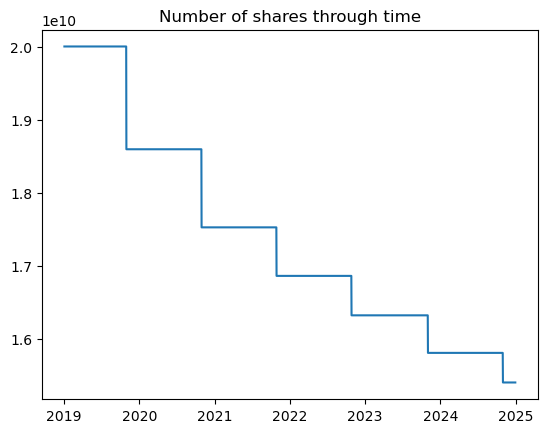

In [158]:
#Plot of outstanding shares 
plt.figure()

plt.title('Number of shares through time')

plt.plot(data.loc['AAPL.O']['Shares used to calculate Diluted EPS - Total'])

plt.show()


## Computing the value of the asset and its volatility

In [159]:
# df_k = pd.DataFrame()

# for ric in rics_list:
#     df = data.loc[ric]
#     df = df.reset_index()
#     df['Total_value'] = (df['Close Price'] * df['Shares used to calculate Diluted EPS - Total']) +df['Debt - Total']
#     # Compute log returns and rolling volatility
#     df['Log_Returns'] = np.log(df['Close Price'] / df['Close Price'].shift(1))
#     df['Rolling_Volatility'] = df['Log_Returns'].rolling(window=252).std() 
#     df = df.dropna(subset=['Rolling_Volatility'])
    
#     # Compute total asset value (equity + debt)
#     #df['Total_value'] = df['Market Capitalization'] + df['Debt - Total']
#     df['RIC'] = ric
#     df = df.set_index([f'RIC', 'Date'])
#     df = df.dropna(how='any')

#     # Drop rows with missing data
    

#     df_k = pd.concat([df, df_k])

# data = df_k.copy()

In [160]:
data.loc[rics_list[1]].describe()

,Close Price,Shares used to calculate Diluted EPS - Total,Market Capitalization,Debt - Total,Log_Returns,Rolling_Volatility,Total_value
count,1490.0,1490.0,1490.0,1490.0,1490.0,1.490000e+03,1490.0
mean,282.980319,2815359060.402685,646818667491.821777,4999157046.979866,0.000947,4.296231e-01,792365798855.704712
std,122.292437,106124307.481707,243063326357.246368,7093153225.599608,0.027136,8.662647e-15,317486544155.381042
min,88.91,2629000000.0,315555188424.080017,0.0,-0.306391,4.296231e-01,254774690000.0
25%,188.475,2702000000.0,376724818057.080017,473000000.0,-0.010946,4.296231e-01,547169780000.0
50%,261.675,2876000000.0,585320975487.75,523000000.0,0.000998,4.296231e-01,747202220000.0
75%,334.73,2888000000.0,909628612618.719971,10610000000.0,0.013921,4.296231e-01,958970779999.999878
max,632.68,2921000000.0,935644813206.599976,19075000000.0,0.209307,4.296231e-01,1682390719999.999756


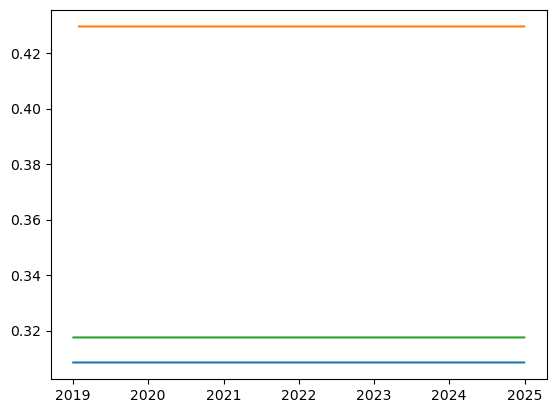

In [161]:
for ric in rics_list:

    plt.plot(data.loc[ric]['Rolling_Volatility'])

In [162]:
# Solve the system for each row
def solve_system(row):
    # Extract parameters from the row
    E = row['Close Price'] * row['Shares used to calculate Diluted EPS - Total'] # Equity (market capitalization)
    sigma_E = row['Rolling_Volatility']  # Rolling volatility as initial guess for sigma_A
    D = row['Debt - Total']          # Debt
    
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']        # Assume a risk-free rate column
    
    T = 1                            # Time to maturity (1 year)
    t = 0                            # Current time

    # Define the system of equations
    def system(vars):
        if D > 0:
            A, sigma_A = vars  # Unknowns: Asset value and asset volatility
            equity_value = af.merton_equity(A, D, r, sigma_A, T, t)
            d1 = (np.log(A / D) + (r + 0.5 * sigma_A**2) * (T - t)) / (sigma_A * np.sqrt(T - t))
            f1 = equity_value - E  # Equation (2)
            f2 = (A / E) * norm.cdf(d1) * sigma_A - sigma_E  # Equation (4)

        else: 

            f1 = E 
            f2 = sigma_E
        return [f1, f2]

    # Initial guesses
    A_guess = row['Total_value']  # Total value (equity + debt)
    sigma_A_guess = row['Rolling_Volatility']  # Rolling volatility

    # Solve the system
    solution = fsolve(system, [A_guess, sigma_A_guess])
    return pd.Series({'A_solution': solution[0], 'sigma_A_solution': solution[1]})

# Apply the solver to the DataFrame
def solve_for_all(df):
    results = df.apply(solve_system, axis=1)
    return pd.concat([df, results], axis=1)


In [163]:
data.isna().sum()

Close Price                                     0
Shares used to calculate Diluted EPS - Total    0
Market Capitalization                           0
Debt - Total                                    0
RIC                                             0
Log_Returns                                     0
Rolling_Volatility                              0
Total_value                                     0
dtype: int64

In [164]:
df_with_solutions = solve_for_all(data)

c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy

In [165]:
df_with_solutions

Close Price  \
Instrument Date                                     
AAPL.O     2019-01-02 00:00:00+00:00        39.48   
           2019-01-03 00:00:00+00:00      35.5475   
           2019-01-04 00:00:00+00:00       37.065   
           2019-01-07 00:00:00+00:00      36.9825   
           2019-01-08 00:00:00+00:00      37.6875   
...                                           ...   
BRBI.MI    2024-12-19 00:00:00+00:00        8.957   
           2024-12-20 00:00:00+00:00         8.99   
           2024-12-23 00:00:00+00:00        8.984   
           2024-12-27 00:00:00+00:00        9.126   
           2024-12-30 00:00:00+00:00        9.093   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AAPL.O     2019-01-02 00:00:00+00:00                                   20000436000   
           2019-01-03 00:00:00+00:00                                   20000436000   
           2019-01-04 00:00:00+00:00                                   20000436000   
           2019-01-07 00:00:00+00:00                                   20000436000   
           2019-01-08 00:00:00+00:00                                   20000436000   
...                                                                            ...   
BRBI.MI    2024-12-19 00:00:00+00:00                                     323640100   
           2024-12-20 00:00:00+00:00                                     323640100   
           2024-12-23 00:00:00+00:00                                     323640100   
           2024-12-27 00:00:00+00:00                                     323640100   
           2024-12-30 00:00:00+00:00                                     323640100   

                                      Market Capitalization    Debt - Total  \
Instrument Date                                                               
AAPL.O     2019-01-02 00:00:00+00:00        1090307495240.0  114483000000.0   
           2019-01-03 00:00:00+00:00        1090307495240.0  114483000000.0   
           2019-01-04 00:00:00+00:00        1090307495240.0  114483000000.0   
           2019-01-07 00:00:00+00:00        1090307495240.0  114483000000.0   
           2019-01-08 00:00:00+00:00        1090307495240.0  114483000000.0   
...                                                     ...             ...   
BRBI.MI    2024-12-19 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-20 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-23 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-27 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-30 00:00:00+00:00           3706536975.0     931124000.0   

                                          RIC  Log_Returns  \
Instrument Date                                              
AAPL.O     2019-01-02 00:00:00+00:00   AAPL.O      0.00114   
           2019-01-03 00:00:00+00:00   AAPL.O    -0.104924   
           2019-01-04 00:00:00+00:00   AAPL.O     0.041803   
           2019-01-07 00:00:00+00:00   AAPL.O    -0.002228   
           2019-01-08 00:00:00+00:00   AAPL.O     0.018884   
...                                       ...          ...   
BRBI.MI    2024-12-19 00:00:00+00:00  BRBI.MI    -0.016828   
           2024-12-20 00:00:00+00:00  BRBI.MI     0.003677   
           2024-12-23 00:00:00+00:00  BRBI.MI    -0.000668   
           2024-12-27 00:00:00+00:00  BRBI.MI     0.015682   
           2024-12-30 00:00:00+00:00  BRBI.MI    -0.003623   

                                      Rolling_Volatility          Total_value  \
Instrument Date                                                                 
AAPL.O     2019-01-02 00:00:00+00:00            0.308473  904100213279.999878   
           2019-01-03 00:00:00+00:00            0.308473       825448498710.0   
           2019-01-04 00:00:00+00:00            0.308473       8557991

In [166]:
x = df_with_solutions['Close Price'] * df_with_solutions['Shares used to calculate Diluted EPS - Total']

asset_value = df_with_solutions['A_solution']

result = asset_value - x
result.describe()

count                 4524.0
mean       38871905707.82869
std        51325899974.43705
min                      0.0
25%         558218664.147461
50%          909805147.73088
75%      107716025602.245117
max      120643447506.040039
dtype: Float64

## Computing the relevant quantities of the Merton's model

In [229]:
def compute_additional_metrics(row):
    # Extract inputs from the row
    """
    V = row['Total_value']  # Asset value
    sigma = row['Rolling_Volatility']  # Asset volatility
    """
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    
    K = row['Debt - Total']  # Debt
    row['Risk_Free_Rate'] = 0.01
    r = row['Risk_Free_Rate']
    
    #print(V/K)

    T = 1  # Time to maturity
    t = 0  # Current time

    # Compute quantities using the provided functions
    equity_value = af.merton_equity(V, K, r, sigma, T, t)
    debt_value = af.merton_debt(V, K, r, sigma, T, t)
    default_probability = af.default_probability(V, K, r, sigma, T, t)
    credit_spread = af.credit_spread_model(V, K, sigma, r, T, t)
    credit_spread_2 = af.credit_spread_model_new(V, K, sigma, r, T, t)

    # Return results as a Series
    return pd.Series({
        'Merton_Equity_Value': equity_value,
        'Merton_Debt_Value': debt_value,
        'Default_Probability': default_probability,
        'Credit_Spread': credit_spread,
        'Credit_Spread_2': credit_spread_2
    })

In [230]:
importlib.reload(af)


# Compute additional metrics for each row
df_with_metrics = df_with_solutions.apply(compute_additional_metrics, axis=1)

# Combine results with the original DataFrame
df_final = pd.concat([df_with_solutions, df_with_metrics], axis=1)

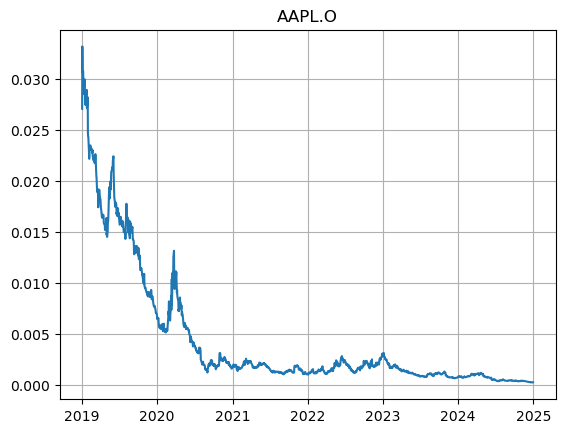

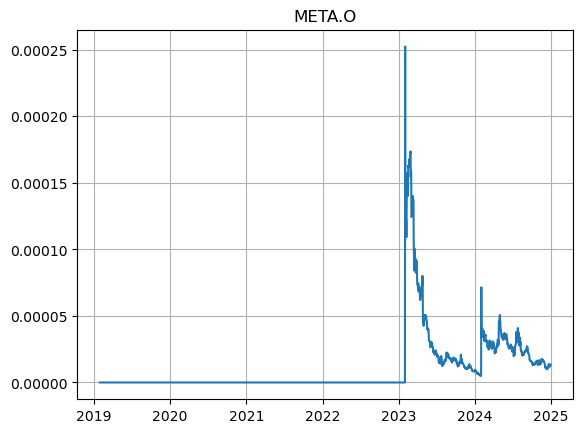

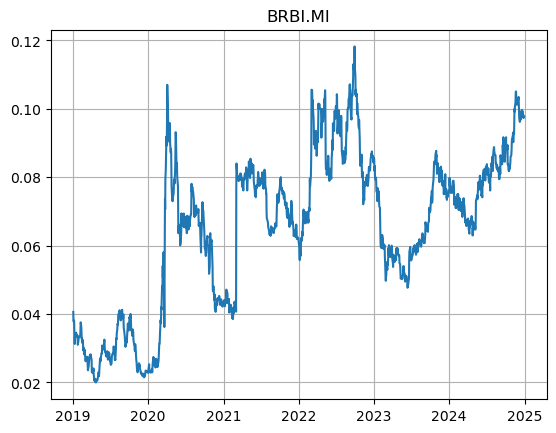

In [231]:
for ric in rics_list:
    plt.figure()

    def_probab = df_final.loc[ric]['Default_Probability']
    plt.plot(def_probab)
    plt.title(f'{ric}')

    plt.grid()

    plt.show()

In [232]:
df_final.loc[rics_list[2]].tail()

,Close Price,Shares used to calculate Diluted EPS - Total,Market Capitalization,Debt - Total,RIC,Log_Returns,Rolling_Volatility,Total_value,A_solution,sigma_A_solution,Merton_Equity_Value,Merton_Debt_Value,Default_Probability,Credit_Spread,Credit_Spread_2
Date,,,,,,,,,,,,,,,
2024-12-19 00:00:00+00:00,8.957,323640100,3706536975.0,931124000.0,BRBI.MI,-0.016828,0.317498,3829968375.7,3.793458e+09,0.242622,2.871599e+09,9.218592e+08,0.099688,2.194748e-10,2.194747e-10
2024-12-20 00:00:00+00:00,8.99,323640100,3706536975.0,931124000.0,BRBI.MI,0.003677,0.317498,3840648499.0,3.804139e+09,0.242833,2.882279e+09,9.218592e+08,0.099215,2.113096e-10,2.113099e-10
2024-12-23 00:00:00+00:00,8.984,323640100,3706536975.0,931124000.0,BRBI.MI,-0.000668,0.317498,3838706658.4,3.802197e+09,0.242794,2.880338e+09,9.218592e+08,0.099301,2.127708e-10,2.127707e-10
2024-12-27 00:00:00+00:00,9.126,323640100,3706536975.0,931124000.0,BRBI.MI,0.015682,0.317498,3884663552.6,3.848154e+09,0.243687,2.926294e+09,9.218592e+08,0.097296,1.808301e-10,1.808300e-10
2024-12-30 00:00:00+00:00,9.093,323640100,3706536975.0,931124000.0,BRBI.MI,-0.003623,0.317498,3873983429.3,3.837474e+09,0.243481,2.915614e+09,9.218592e+08,0.097757,1.877827e-10,1.877826e-10


In [233]:
print(df_final.loc[rics_list[0]]['Default_Probability'].describe())

count    1509.000000
mean        0.004353
std         0.006081
min         0.000242
25%         0.001101
50%         0.001724
75%         0.003820
max         0.033144
Name: Default_Probability, dtype: float64


In [234]:
print((df_final.loc[rics_list[0]]['Credit_Spread'] - df_final.loc[rics_list[0]]['Credit_Spread_2']).describe())

count    1.509000e+03
mean     9.343825e-18
std      9.362030e-17
min     -5.551115e-16
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.551115e-16
dtype: float64


In [235]:
3.793458e+09 / (931124000.0 *np.exp(-r * (1)))
np.log(4.074063175259149)

1.4046408246208455

In [241]:
row = df_final.loc[rics_list[2]].iloc[-1]
print(row['A_solution'] / row['Debt - Total'])
print(row)


4.12133457512933
Close Price                                                 9.093
Shares used to calculate Diluted EPS - Total            323640100
Market Capitalization                                3706536975.0
Debt - Total                                          931124000.0
RIC                                                       BRBI.MI
Log_Returns                                             -0.003623
Rolling_Volatility                                       0.317498
Total_value                                          3873983429.3
A_solution                                      3837473534.932722
sigma_A_solution                                         0.243481
Merton_Equity_Value                             2915614373.705971
Merton_Debt_Value                                921859161.226751
Default_Probability                                      0.097757
Credit_Spread                                                 0.0
Credit_Spread_2                                            

In [260]:
r = 0.04
T = 5
t = 0

sigma = 0.317498

K = 931124000.0 * 2
V = 3837473534.932722

p_0 = np.exp(-r * (T - t))

# 2) Calculate d1 and d2
d1 = (-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t)) / (sigma * np.sqrt(T -t))

d2 = d1 - (sigma * np.sqrt(T - t))

# 3) *Defaultable* bond price using Merton's debt formula
#defaultable_bond = K * riskless * norm.cdf(d2) + V * (1 - norm.cdf(d1))

# 4) Credit spread calculation: -1/(T - t) * ln(defaultable_bond / riskless_bond)
credit_spread = -1/(T - t) * np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))

print(f'Debt-to-value: {K/V}')
print(f'Log: {-(np.log((K*p_0)/V))}')
print(f'Numerator: {(-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t))}')
print(f'Volatility: {sigma}')
print(f'd1: {d1}')
print(f'First addend: {np.log(norm.cdf(d2) )}' )
print(f'Second addend: {(V/(K *p_0))*norm.cdf(-d1)}')
print(f'Not discounted: {-np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))}')
print(f'Credit spread: {credit_spread}')

Debt-to-value: 0.48527969849117114
Log: 0.9230298563510537
Numerator: 1.1750423063610538
Volatility: 0.317498
d1: 1.6551124564321347
First addend: -0.1890890860512775
Second addend: 0.12320461050463193
Not discounted: 0.05032810112291306
Credit spread: 0.010065620224582614


In [237]:
af.credit_spread_model_new(V = 40, K = 15, sigma = 0.4, r = 0.04, T = 5, t = 0)

0.013587038390588863

## Ratings of S&P 500

In [238]:
ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI)',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI,Sdate=-10Y)'])
print(ratings_data.head())

ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating'])
print(ratings_data.head())

c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


  Instrument        Company Common Name  Issuer Rating  Issuer Rating
0    POOL.OQ                  Pool Corp           <NA>           <NA>
1    CHRW.OQ  CH Robinson Worldwide Inc           <NA>           <NA>
2      AJG.N  Arthur J. Gallagher & Co.           <NA>           <NA>
3      CNP.N     CenterPoint Energy Inc           <NA>           <NA>
4     AMCR.N                  Amcor PLC           <NA>           <NA>
  Instrument        Company Common Name Issuer Rating
0    POOL.OQ                  Pool Corp           A1+
1    CHRW.OQ  CH Robinson Worldwide Inc           A1+
2      AJG.N  Arthur J. Gallagher & Co.          Baa2
3      CNP.N     CenterPoint Energy Inc          Baa3
4     AMCR.N                  Amcor PLC          Baa2


c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [239]:
ratings_data['Issuer Rating'].value_counts()

Issuer Rating
Baa2            51
Baa1            49
A1+             39
A1              39
                35
P-2             30
A2              25
Baa3            24
A3              20
NR              19
BBB             17
A               13
P-1             12
BBB+            11
Ba1             11
Aa3             10
BBB-             9
WR               9
A-               7
F1               6
A+               6
WD               6
Ba2              6
Discontinued     5
BB+              4
BB               4
F2               4
Aa2              4
P-3              3
Ba3              2
BB-              2
B-               2
B1               2
F3               2
AA-              2
B                2
LGD2 - 20%       1
Aaa              1
LGD4 - 68%       1
(P)Baa3          1
B+               1
LGD5 - 74%       1
LGD5 - 81%       1
(P)A2            1
AA               1
(P)Baa2          1
LGD4 - 54%       1
Name: count, dtype: Int64

In [240]:
ratings_data[ratings_data['Issuer Rating'] == 'B1']

,Instrument,Company Common Name,Issuer Rating
63,DAY.N,Dayforce Inc,B1
346,CZR.OQ,Caesars Entertainment Inc,B1
